The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.16.1


# Natural Language Inference: Using Attention
:label:`sec_natural-language-inference-attention`

We introduced the natural language inference task and the SNLI dataset in :numref:`sec_natural-language-inference-and-dataset`. In view of many models that are based on complex and deep architectures, Parikh et al. proposed to address natural language inference with attention mechanisms and called it a "decomposable attention model" :cite:`Parikh.Tackstrom.Das.ea.2016`.
This results in a model without recurrent or convolutional layers, achieving the best result at the time on the SNLI dataset with much fewer parameters.
In this section, we will describe and implement this attention-based method (with MLPs) for natural language inference, as depicted in :numref:`fig_nlp-map-nli-attention`.

![This section feeds pretrained GloVe to an architecture based on attention and MLPs for natural language inference.](../img/nlp-map-nli-attention.svg)
:label:`fig_nlp-map-nli-attention`


## The Model

Simpler than preserving the order of words in premises and hypotheses,
we can just align words in one text sequence to every word in the other, and vice versa,
then compare and aggregate such information to predict the logical relationships
between premises and hypotheses.
Similar to alignment of words between source and target sentences in machine translation,
the alignment of words between premises and hypotheses
can be neatly accomplished by attention mechanisms.

![Natural language inference using attention mechanisms. ](../img/nli-attention.svg)
:label:`fig_nli_attention`

:numref:`fig_nli_attention` depicts the natural language inference method using attention mechanisms.
At a high level, it consists of three jointly trained steps: attending, comparing, and aggregating.
We will illustrate them step by step in the following.


In [1]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F

### Attending

The first step is to align words in one text sequence to each word in the other sequence.
Suppose that the premise is "i do need sleep" and the hypothesis is "i am tired".
Due to semantical similarity,
we may wish to align "i" in the hypothesis with "i" in the premise,
and align "tired" in the hypothesis with "sleep" in the premise.
Likewise, we may wish to align "i" in the premise with "i" in the hypothesis,
and align "need" and "sleep" in the premise with "tired" in the hypothesis.
Note that such alignment is *soft* using weighted average,
where ideally large weights are associated with the words to be aligned.
For ease of demonstration, :numref:`fig_nli_attention` shows such alignment in a *hard* way.

Now we describe the soft alignment using attention mechanisms in more detail.
Denote by $\mathbf{A} = (\mathbf{a}_1, \ldots, \mathbf{a}_m)$
and $\mathbf{B} = (\mathbf{b}_1, \ldots, \mathbf{b}_n)$ the premise and hypothesis,
whose number of words are $m$ and $n$, respectively,
where $\mathbf{a}_i, \mathbf{b}_j \in \mathbb{R}^{d}$ ($i = 1, \ldots, m, j = 1, \ldots, n$) is a $d$-dimensional word embedding vector.
For soft alignment, we compute the attention weights $e_{ij} \in \mathbb{R}$ as

$$e_{ij} = f(\mathbf{a}_i)^\top f(\mathbf{b}_j),$$
:eqlabel:`eq_nli_e`

where the function $f$ is an MLP defined in the following `mlp` function.
The output dimension of $f$ is specified by the `num_hiddens` argument of `mlp`.


In [2]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

It should be highlighted that, in :eqref:`eq_nli_e`
$f$ takes inputs $\mathbf{a}_i$ and $\mathbf{b}_j$ separately rather than takes a pair of them together as the input.
This *decomposition* trick leads to only $m + n$ applications (linear complexity) of $f$ rather than $mn$ applications
(quadratic complexity).


Normalizing the attention weights in :eqref:`eq_nli_e`,
we compute the weighted average of all the word embeddings in the hypothesis
to obtain representation of the hypothesis that is softly aligned with the word indexed by $i$ in the premise:

$$
\boldsymbol{\beta}_i = \sum_{j=1}^{n}\frac{\exp(e_{ij})}{ \sum_{k=1}^{n} \exp(e_{ik})} \mathbf{b}_j.
$$

Likewise, we compute soft alignment of premise words for each word indexed by $j$ in the hypothesis:

$$
\boldsymbol{\alpha}_j = \sum_{i=1}^{m}\frac{\exp(e_{ij})}{ \sum_{k=1}^{m} \exp(e_{kj})} \mathbf{a}_i.
$$

Below we define the `Attend` class to compute the soft alignment of hypotheses (`beta`) with input premises `A` and soft alignment of premises (`alpha`) with input hypotheses `B`.


In [3]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of words in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of words in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of words in sequence A,
        # no. of words in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of words in sequence A,
        # `embed_size`), where sequence B is softly aligned with each word
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of words in sequence B,
        # `embed_size`), where sequence A is softly aligned with each word
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

### Comparing

In the next step, we compare a word in one sequence with the other sequence that is softly aligned with that word.
Note that in soft alignment, all the words from one sequence, though with probably different attention weights, will be compared with a word in the other sequence.
For easy of demonstration, :numref:`fig_nli_attention` pairs words with aligned words in a *hard* way.
For example, suppose that the attending step determines that "need" and "sleep" in the premise are both aligned with "tired" in the hypothesis, the pair "tired--need sleep" will be compared.

In the comparing step, we feed the concatenation (operator $[\cdot, \cdot]$) of words from one sequence and aligned words from the other sequence into a function $g$ (an MLP):

$$\mathbf{v}_{A,i} = g([\mathbf{a}_i, \boldsymbol{\beta}_i]), i = 1, \ldots, m\\ \mathbf{v}_{B,j} = g([\mathbf{b}_j, \boldsymbol{\alpha}_j]), j = 1, \ldots, n.$$

:eqlabel:`eq_nli_v_ab`


In :eqref:`eq_nli_v_ab`, $\mathbf{v}_{A,i}$ is the comparison between word $i$ in the premise and all the hypothesis words that are softly aligned with word $i$;
while $\mathbf{v}_{B,j}$ is the comparison between word $j$ in the hypothesis and all the premise words that are softly aligned with word $j$.
The following `Compare` class defines such as comparing step.


In [4]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

### Aggregating

With two sets of comparison vectors $\mathbf{v}_{A,i}$ ($i = 1, \ldots, m$) and $\mathbf{v}_{B,j}$ ($j = 1, \ldots, n$) on hand,
in the last step we will aggregate such information to infer the logical relationship.
We begin by summing up both sets:

$$
\mathbf{v}_A = \sum_{i=1}^{m} \mathbf{v}_{A,i}, \quad \mathbf{v}_B = \sum_{j=1}^{n}\mathbf{v}_{B,j}.
$$

Next we feed the concatenation of both summarization results into function $h$ (an MLP) to obtain the classification result of the logical relationship:

$$
\hat{\mathbf{y}} = h([\mathbf{v}_A, \mathbf{v}_B]).
$$

The aggregation step is defined in the following `Aggregate` class.


In [5]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

### Putting All Things Together

By putting the attending, comparing, and aggregating steps together,
we define the decomposable attention model to jointly train these three steps.


In [6]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

## Training and Evaluating the Model

Now we will train and evaluate the defined decomposable attention model on the SNLI dataset.
We begin by reading the dataset.


### Reading the dataset

We download and read the SNLI dataset using the function defined in :numref:`sec_natural-language-inference-and-dataset`. The batch size and sequence length are set to $256$ and $50$, respectively.


In [7]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples


read 9824 examples


### Creating the Model

We use the pretrained $100$-dimensional GloVe embedding to represent the input tokens.
Thus, we predefine the dimension of vectors $\mathbf{a}_i$ and $\mathbf{b}_j$ in :eqref:`eq_nli_e` as $100$.
The output dimension of functions $f$ in :eqref:`eq_nli_e` and $g$ in :eqref:`eq_nli_v_ab` is set to $200$.
Then we create a model instance, initialize its parameters,
and load the GloVe embedding to initialize vectors of input tokens.


In [8]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

### Training and Evaluating the Model

In contrast to the `split_batch` function in :numref:`sec_multi_gpu` that takes single inputs such as text sequences (or images),
we define a `split_batch_multi_inputs` function to take multiple inputs such as premises and hypotheses in minibatches.


Now we can train and evaluate the model on the SNLI dataset.


loss 0.493, train acc 0.806, test acc 0.827
17472.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


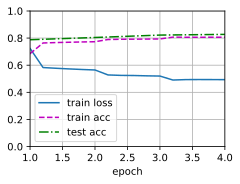

In [9]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### Using the Model

Finally, define the prediction function to output the logical relationship between a pair of premise and hypothesis.


In [10]:
#@save
def predict_snli(net, vocab, premise, hypothesis):
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

We can use the trained model to obtain the natural language inference result for a sample pair of sentences.


In [11]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

## Summary

* The decomposable attention model consists of three steps for predicting the logical relationships between premises and hypotheses: attending, comparing, and aggregating.
* With attention mechanisms, we can align words in one text sequence to every word in the other, and vice versa. Such alignment is soft using weighted average, where ideally large weights are associated with the words to be aligned.
* The decomposition trick leads to a more desirable linear complexity than quadratic complexity when computing attention weights.
* We can use pretrained word embedding as the input representation for downstream natural language processing task such as natural language inference.


## Exercises

1. Train the model with other combinations of hyperparameters. Can you get better accuracy on the test set?
1. What are major drawbacks of the decomposable attention model for natural language inference?
1. Suppose that we want to get the level of semantical similarity (e.g., a continuous value between $0$ and $1$) for any pair of sentences. How shall we collect and label the dataset? Can you design a model with attention mechanisms?


[Discussions](https://discuss.d2l.ai/t/1530)
